# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 5s 31ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 18.9648 - energy_loss: 0.2360 - force_loss: 0.9364 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9288 - energy_loss: 0.2052 - force_loss: 0.9362 - 564ms/epoch - 70ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9148 - energy_loss: 0.2064 - force_loss: 0.9354 - 553ms/epoch - 69ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8286 - energy_loss: 0.2200 - force_loss: 0.9304 - 555ms/epoch - 69ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.6919 - energy_loss: 0.3329 - force_loss: 0.9179 - 558ms/epoch - 70ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.4989 - energy_loss: 0.3279 - force_loss: 0.9086 - 547ms/epoch - 68ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.2134 - energy_loss: 0.4391 - force_loss: 0.8887 - 561ms/epoch - 70ms/step
Epoch 8/1500
8/8 - 1s - loss: 17.8618 - energy_loss: 0.7263 - force_loss: 0.8568 - 552ms/epoch - 69ms/step
Epoch 9/1500
8/8 - 1s - loss: 16.9356 - energy_loss: 0.8744 - force_loss: 0.8031 - 574ms/epoch - 72ms/step
Epoch 10/1500
8/8 - 1s - loss: 17.5289 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.6955 - energy_loss: 0.8148 - force_loss: 0.2940 - 582ms/epoch - 73ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.6123 - energy_loss: 0.7847 - force_loss: 0.2914 - 580ms/epoch - 73ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.5304 - energy_loss: 0.7663 - force_loss: 0.2882 - 593ms/epoch - 74ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.4901 - energy_loss: 0.7517 - force_loss: 0.2869 - 567ms/epoch - 71ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.5343 - energy_loss: 0.8136 - force_loss: 0.2860 - 569ms/epoch - 71ms/step
Epoch 83/1500
8/8 - 1s - loss: 5.9759 - energy_loss: 0.3643 - force_loss: 0.2806 - 566ms/epoch - 71ms/step
Epoch 84/1500
8/8 - 1s - loss: 5.9139 - energy_loss: 0.3450 - force_loss: 0.2784 - 596ms/epoch - 75ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.7027 - energy_loss: 1.0825 - force_loss: 0.2810 - 625ms/epoch - 78ms/step
Epoch 86/1500
8/8 - 1s - loss: 7.0606 - energy_loss: 1.2775 - force_loss: 0.2892 - 611ms/epoch - 76ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.9079

8/8 - 1s - loss: 4.8925 - energy_loss: 1.0230 - force_loss: 0.1935 - 543ms/epoch - 68ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.7156 - energy_loss: 0.8067 - force_loss: 0.1954 - 643ms/epoch - 80ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.5276 - energy_loss: 0.6141 - force_loss: 0.1957 - 650ms/epoch - 81ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.5831 - energy_loss: 0.4894 - force_loss: 0.2047 - 577ms/epoch - 72ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.2522 - energy_loss: 0.3792 - force_loss: 0.1937 - 624ms/epoch - 78ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.1465 - energy_loss: 0.3499 - force_loss: 0.1898 - 546ms/epoch - 68ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.0749 - energy_loss: 0.3676 - force_loss: 0.1854 - 549ms/epoch - 69ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.8043 - energy_loss: 1.0795 - force_loss: 0.1862 - 543ms/epoch - 68ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.5899 - energy_loss: 0.7329 - force_loss: 0.1929 - 584ms/epoch - 73ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.5267 - en

Epoch 230/1500
8/8 - 1s - loss: 3.6557 - energy_loss: 0.4749 - force_loss: 0.1590 - 553ms/epoch - 69ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.7680 - energy_loss: 0.6765 - force_loss: 0.1546 - 557ms/epoch - 70ms/step
Epoch 232/1500
8/8 - 1s - loss: 4.1831 - energy_loss: 1.0543 - force_loss: 0.1564 - 594ms/epoch - 74ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.5633 - energy_loss: 0.3483 - force_loss: 0.1607 - 583ms/epoch - 73ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.3044 - energy_loss: 0.2509 - force_loss: 0.1527 - 574ms/epoch - 72ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.2814 - energy_loss: 0.2721 - force_loss: 0.1505 - 588ms/epoch - 73ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.4729 - energy_loss: 0.4804 - force_loss: 0.1496 - 578ms/epoch - 72ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.6436 - energy_loss: 0.5874 - force_loss: 0.1528 - 558ms/epoch - 70ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.6992 - energy_loss: 0.5870 - force_loss: 0.1556 - 581ms/epoch - 73ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.1756 - energy_loss: 0.4886 - force_loss: 0.1344 - 543ms/epoch - 68ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.2864 - energy_loss: 0.5515 - force_loss: 0.1367 - 543ms/epoch - 68ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.1964 - energy_loss: 0.5030 - force_loss: 0.1347 - 550ms/epoch - 69ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.2314 - energy_loss: 0.5092 - force_loss: 0.1361 - 536ms/epoch - 67ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.2451 - energy_loss: 0.5154 - force_loss: 0.1365 - 545ms/epoch - 68ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.2679 - energy_loss: 0.4890 - force_loss: 0.1389 - 557ms/epoch - 70ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.3691 - energy_loss: 0.5317 - force_loss: 0.1419 - 567ms/epoch - 71ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.2724 - energy_loss: 0.5227 - force_loss: 0.1375 - 561ms/epoch - 70ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.2920 - energy_loss: 0.5534 - force_loss: 0.1369 - 557ms/epoch - 70ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 2.9390 - energy_loss: 0.4811 - force_loss: 0.1229 - 556ms/epoch - 69ms/step
Epoch 383/1500
8/8 - 1s - loss: 3.1760 - energy_loss: 0.4529 - force_loss: 0.1362 - 552ms/epoch - 69ms/step
Epoch 384/1500
8/8 - 1s - loss: 3.4059 - energy_loss: 0.4801 - force_loss: 0.1463 - 560ms/epoch - 70ms/step
Epoch 385/1500
8/8 - 1s - loss: 3.2000 - energy_loss: 0.4863 - force_loss: 0.1357 - 561ms/epoch - 70ms/step
Epoch 386/1500
8/8 - 1s - loss: 3.5248 - energy_loss: 0.9509 - force_loss: 0.1287 - 551ms/epoch - 69ms/step
Epoch 387/1500
8/8 - 1s - loss: 2.7390 - energy_loss: 0.2509 - force_loss: 0.1244 - 545ms/epoch - 68ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.7547 - energy_loss: 0.3570 - force_loss: 0.1199 - 552ms/epoch - 69ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.8498 - energy_loss: 0.4445 - force_loss: 0.1203 - 561ms/epoch - 70ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.9080 - energy_loss: 0.5343 - force_loss: 0.1187 - 558ms/epoch - 70ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.6934 - energy_loss: 0.4463 - force_loss: 0.1124 - 546ms/epoch - 68ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.6376 - energy_loss: 0.3480 - force_loss: 0.1145 - 551ms/epoch - 69ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.5377 - energy_loss: 0.2556 - force_loss: 0.1141 - 556ms/epoch - 69ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.3334 - energy_loss: 0.1663 - force_loss: 0.1084 - 546ms/epoch - 68ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.3127 - energy_loss: 0.2161 - force_loss: 0.1048 - 545ms/epoch - 68ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.3038 - energy_loss: 0.1915 - force_loss: 0.1056 - 542ms/epoch - 68ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.5906 - energy_loss: 0.4175 - force_loss: 0.1087 - 552ms/epoch - 69ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.4632 - energy_loss: 0.2212 - force_loss: 0.1121 - 544ms/epoch - 68ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.3895 - energy_loss: 0.1886 - force_loss: 0.1100 - 547ms/epoch - 68ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.6621 - energy_loss: 0.4446 - force_loss: 0.1109 - 585ms/epoch - 73ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.4896 - energy_loss: 0.4163 - force_loss: 0.1037 - 621ms/epoch - 78ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.5503 - energy_loss: 0.4183 - force_loss: 0.1066 - 638ms/epoch - 80ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.5269 - energy_loss: 0.4258 - force_loss: 0.1051 - 564ms/epoch - 71ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.4902 - energy_loss: 0.4068 - force_loss: 0.1042 - 572ms/epoch - 71ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.5124 - energy_loss: 0.4422 - force_loss: 0.1035 - 556ms/epoch - 69ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.4102 - energy_loss: 0.4016 - force_loss: 0.1004 - 557ms/epoch - 70ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.3967 - energy_loss: 0.4070 - force_loss: 0.0995 - 574ms/epoch - 72ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.4648 - energy_loss: 0.3996 - force_loss: 0.1033 - 564ms/epoch - 71ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.1250 - energy_loss: 0.2491 - force_loss: 0.0938 - 601ms/epoch - 75ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.3644 - energy_loss: 0.4214 - force_loss: 0.0972 - 715ms/epoch - 89ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.4744 - energy_loss: 0.4321 - force_loss: 0.1021 - 623ms/epoch - 78ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.5108 - energy_loss: 0.3725 - force_loss: 0.1069 - 619ms/epoch - 77ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.3941 - energy_loss: 0.3108 - force_loss: 0.1042 - 590ms/epoch - 74ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.3165 - energy_loss: 0.2306 - force_loss: 0.1043 - 574ms/epoch - 72ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.3996 - energy_loss: 0.3868 - force_loss: 0.1006 - 613ms/epoch - 77ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.4452 - energy_loss: 0.4874 - force_loss: 0.0979 - 589ms/epoch - 74ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.3270 - energy_loss: 0.3626 - force_loss: 0.0982 - 572ms/epoch - 72ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.2685 - energy_loss: 0.3880 - force_loss: 0.0940 - 574ms/epoch - 72ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.2228 - energy_loss: 0.3908 - force_loss: 0.0916 - 577ms/epoch - 72ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.2104 - energy_loss: 0.3446 - force_loss: 0.0933 - 573ms/epoch - 72ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.1047 - energy_loss: 0.2148 - force_loss: 0.0945 - 560ms/epoch - 70ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.4749 - energy_loss: 0.6333 - force_loss: 0.0921 - 571ms/epoch - 71ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.4317 - energy_loss: 0.5920 - force_loss: 0.0920 - 577ms/epoch - 72ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.2627 - energy_loss: 0.4485 - force_loss: 0.0907 - 577ms/epoch - 72ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.2543 - energy_loss: 0.3805 - force_loss: 0.0937 - 577ms/epoch - 72ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.3979 - energy_loss: 0.4793 - force_loss: 0.0959 - 613ms/epoch - 77ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.2569 - energy_loss: 0.3693 - force_loss: 0.0944 - 729ms/epoch - 91ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.4254 - energy_loss: 0.3740 - force_loss: 0.1026 - 663ms/epoch - 83ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.2715 - energy_loss: 0.3299 - force_loss: 0.0971 - 658ms/epoch - 82ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.1265 - energy_loss: 0.1796 - force_loss: 0.0973 - 612ms/epoch - 77ms/step
Epoch 766/1500
8/8 - 1s - loss: 1.9958 - energy_loss: 0.1876 - force_loss: 0.0904 - 645ms/epoch - 81ms/step
Epoch 767/1500
8/8 - 1s - loss: 1.8955 - energy_loss: 0.1820 - force_loss: 0.0857 - 569ms/epoch - 71ms/step
Epoch 768/1500
8/8 - 1s - loss: 1.8871 - energy_loss: 0.1600 - force_loss: 0.0864 - 693ms/epoch - 87ms/step
Epoch 769/1500
8/8 - 1s - loss: 1.9467 - energy_loss: 0.2034 - force_loss: 0.0872 - 646ms/epoch - 81ms/step
Epoch 770/1500
8/8 - 1s - loss: 1.8995 - energy_loss: 0.1750 - force_loss: 0.0862 - 634ms/epoch - 79ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.0531 - energy_loss: 0.3102 - force_loss: 0.0871 - 563ms/epoch - 70ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.0556 - energy_loss: 0.3480 - force_loss: 0.0854 - 555ms/epoch - 69ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.1430 - energy_loss: 0.3912 - force_loss: 0.0876 - 553ms/epoch - 69ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.2236 - energy_loss: 0.3478 - force_loss: 0.0938 - 560ms/epoch - 70ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.2881 - energy_loss: 0.3814 - force_loss: 0.0953 - 559ms/epoch - 70ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.2275 - energy_loss: 0.3980 - force_loss: 0.0915 - 555ms/epoch - 69ms/step
Epoch 844/1500
8/8 - 1s - loss: 1.9954 - energy_loss: 0.1733 - force_loss: 0.0911 - 556ms/epoch - 69ms/step
Epoch 845/1500
8/8 - 1s - loss: 1.9223 - energy_loss: 0.1596 - force_loss: 0.0881 - 557ms/epoch - 70ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.0639 - energy_loss: 0.3471 - force_loss: 0.0858 - 559ms/epoch - 70ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.0063 - energy_loss: 0.3321 - force_loss: 0.0837 - 558ms/epoch - 70ms/step
Epoch 915/1500
8/8 - 1s - loss: 1.8164 - energy_loss: 0.1496 - force_loss: 0.0833 - 551ms/epoch - 69ms/step
Epoch 916/1500
8/8 - 1s - loss: 1.7783 - energy_loss: 0.1717 - force_loss: 0.0803 - 559ms/epoch - 70ms/step
Epoch 917/1500
8/8 - 1s - loss: 1.7584 - energy_loss: 0.1592 - force_loss: 0.0800 - 548ms/epoch - 69ms/step
Epoch 918/1500
8/8 - 1s - loss: 1.7515 - energy_loss: 0.1674 - force_loss: 0.0792 - 550ms/epoch - 69ms/step
Epoch 919/1500
8/8 - 1s - loss: 1.7222 - energy_loss: 0.1613 - force_loss: 0.0780 - 539ms/epoch - 67ms/step
Epoch 920/1500
8/8 - 1s - loss: 1.7375 - energy_loss: 0.1749 - force_loss: 0.0781 - 541ms/epoch - 68ms/step
Epoch 921/1500
8/8 - 1s - loss: 1.7442 - energy_loss: 0.1829 - force_loss: 0.0781 - 550ms/epoch - 69ms/step
Epoch 922/1500
8/8 - 1s - loss: 1.7041 - energy_loss: 0.1704 - force_loss: 0.0767 - 546ms/epoch - 68ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 1.7548 - energy_loss: 0.1546 - force_loss: 0.0800 - 681ms/epoch - 85ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.7271 - energy_loss: 0.1515 - force_loss: 0.0788 - 658ms/epoch - 82ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.7096 - energy_loss: 0.1402 - force_loss: 0.0785 - 643ms/epoch - 80ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.7148 - energy_loss: 0.1719 - force_loss: 0.0771 - 664ms/epoch - 83ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.6638 - energy_loss: 0.1616 - force_loss: 0.0751 - 670ms/epoch - 84ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.8099 - energy_loss: 0.2910 - force_loss: 0.0759 - 676ms/epoch - 84ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.8787 - energy_loss: 0.3066 - force_loss: 0.0786 - 668ms/epoch - 83ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.9688 - energy_loss: 0.3371 - force_loss: 0.0816 - 658ms/epoch - 82ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.2866 - energy_loss: 0.6463 - force_loss: 0.0820 - 658ms/epoch - 82ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 2.0004 - energy_loss: 0.2694 - force_loss: 0.0866 - 586ms/epoch - 73ms/step
Epoch 1067/1500
8/8 - 1s - loss: 2.0743 - energy_loss: 0.3213 - force_loss: 0.0877 - 581ms/epoch - 73ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.9705 - energy_loss: 0.3362 - force_loss: 0.0817 - 586ms/epoch - 73ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.2213 - energy_loss: 0.6277 - force_loss: 0.0797 - 580ms/epoch - 73ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.2003 - energy_loss: 0.5455 - force_loss: 0.0827 - 582ms/epoch - 73ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.9680 - energy_loss: 0.2766 - force_loss: 0.0846 - 588ms/epoch - 74ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.7241 - energy_loss: 0.1233 - force_loss: 0.0800 - 581ms/epoch - 73ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.6654 - energy_loss: 0.1631 - force_loss: 0.0751 - 587ms/epoch - 73ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.6504 - energy_loss: 0.1624 - force_loss: 0.0744 - 590ms/epoch - 74ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.7628 - energy_loss: 0.3109 - force_loss: 0.0726 - 568ms/epoch - 71ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.8375 - energy_loss: 0.3384 - force_loss: 0.0750 - 573ms/epoch - 72ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.8913 - energy_loss: 0.3271 - force_loss: 0.0782 - 573ms/epoch - 72ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.9532 - energy_loss: 0.3296 - force_loss: 0.0812 - 571ms/epoch - 71ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.7836 - energy_loss: 0.1518 - force_loss: 0.0816 - 572ms/epoch - 72ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.6513 - energy_loss: 0.1623 - force_loss: 0.0744 - 569ms/epoch - 71ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.5832 - energy_loss: 0.1443 - force_loss: 0.0719 - 574ms/epoch - 72ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.5962 - energy_loss: 0.1546 - force_loss: 0.0721 - 569ms/epoch - 71ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.5537 - energy_loss: 0.1331 - force_loss: 0.0710 - 566ms/epoch - 71ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.8765 - energy_loss: 0.3325 - force_loss: 0.0772 - 569ms/epoch - 71ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8138 - energy_loss: 0.3137 - force_loss: 0.0750 - 608ms/epoch - 76ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.8041 - energy_loss: 0.3196 - force_loss: 0.0742 - 575ms/epoch - 72ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.8811 - energy_loss: 0.3093 - force_loss: 0.0786 - 567ms/epoch - 71ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.8883 - energy_loss: 0.3338 - force_loss: 0.0777 - 564ms/epoch - 71ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.8464 - energy_loss: 0.3251 - force_loss: 0.0761 - 569ms/epoch - 71ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.8031 - energy_loss: 0.3220 - force_loss: 0.0741 - 568ms/epoch - 71ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.7746 - energy_loss: 0.3093 - force_loss: 0.0733 - 573ms/epoch - 72ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.7120 - energy_loss: 0.3208 - force_loss: 0.0696 - 577ms/epoch - 72ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.8698 - energy_loss: 0.3706 - force_loss: 0.0750 - 610ms/epoch - 76ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.8268 - energy_loss: 0.2774 - force_loss: 0.0775 - 645ms/epoch - 81ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.7237 - energy_loss: 0.3004 - force_loss: 0.0712 - 611ms/epoch - 76ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.7796 - energy_loss: 0.3744 - force_loss: 0.0703 - 603ms/epoch - 75ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.6922 - energy_loss: 0.2727 - force_loss: 0.0710 - 598ms/epoch - 75ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.7245 - energy_loss: 0.2860 - force_loss: 0.0719 - 614ms/epoch - 77ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.8538 - energy_loss: 0.2733 - force_loss: 0.0790 - 618ms/epoch - 77ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.9914 - energy_loss: 0.3206 - force_loss: 0.0835 - 652ms/epoch - 81ms/step
Epoch 1302/1500
8/8 - 1s - loss: 2.0053 - energy_loss: 0.3555 - force_loss: 0.0825 - 633ms/epoch - 79ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.7885 - energy_loss: 0.3029 - force_loss: 0.0743 - 584ms/epoch - 73ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.8967 - energy_loss: 0.3072 - force_loss: 0.0795 - 579ms/epoch - 72ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7590 - energy_loss: 0.3019 - force_loss: 0.0729 - 668ms/epoch - 83ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7160 - energy_loss: 0.3050 - force_loss: 0.0706 - 657ms/epoch - 82ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.7361 - energy_loss: 0.2934 - force_loss: 0.0721 - 631ms/epoch - 79ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.7108 - energy_loss: 0.3144 - force_loss: 0.0698 - 656ms/epoch - 82ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.7204 - energy_loss: 0.2977 - force_loss: 0.0711 - 671ms/epoch - 84ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.7563 - energy_loss: 0.2909 - force_loss: 0.0733 - 668ms/epoch - 84ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6346 - energy_loss: 0.2272 - force_loss: 0.0704 - 677ms/epoch - 85ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.7595 - energy_loss: 0.3143 - force_loss: 0.0723 - 668ms/epoch - 83ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7839 - energy_loss: 0.2968 - force_loss: 0.0744 - 637ms/epoch - 80ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.8501 - energy_loss: 0.3171 - force_loss: 0.0766 - 607ms/epoch - 76ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8423 - energy_loss: 0.3111 - force_loss: 0.0766 - 599ms/epoch - 75ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.7719 - energy_loss: 0.3149 - force_loss: 0.0729 - 590ms/epoch - 74ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.6898 - energy_loss: 0.3050 - force_loss: 0.0692 - 605ms/epoch - 76ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.7285 - energy_loss: 0.3019 - force_loss: 0.0713 - 587ms/epoch - 73ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.7353 - energy_loss: 0.2921 - force_loss: 0.0722 - 631ms/epoch - 79ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.7460 - energy_loss: 0.2918 - force_loss: 0.0727 - 610ms/epoch - 76ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

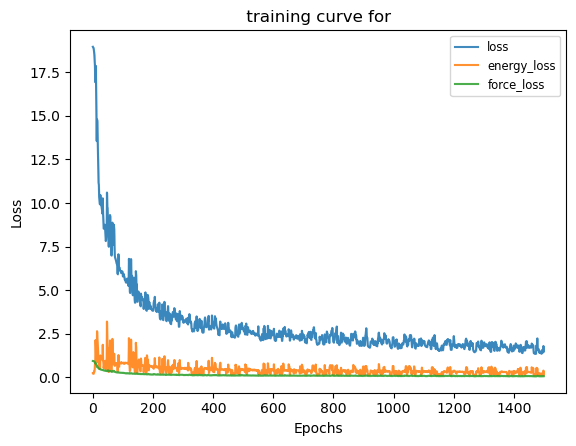

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.molecule.dynamics.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3    
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array([-17469.93773643]),
 'forces': array([[-2.7132425 ,  2.6324928 , -0.8572875 ],
        [-0.97317815, -0.7775682 ,  2.0001655 ],
        [ 3.1139636 , -2.2221723 , -0.16951466],
        [-0.3930836 ,  1.7100642 , -0.12173671],
        [ 0.08054575,  1.7851715 ,  0.875232  ],
        [-0.5686051 ,  0.29877377, -0.07371674],
        [ 0.12676695,  0.75162274, -2.1048515 ],
        [-0.35483456, -1.260961  , -0.08978322],
        [ 0.578259  ,  3.7664082 ,  2.0042741 ],
        [-0.71331376,  2.0356033 ,  0.7027037 ],
        [ 1.2335918 , -1.15589   ,  0.47359446],
        [ 0.43241405, -3.6935205 , -1.9068377 ],
        [ 1.8842303 , -1.0471797 , -0.6878532 ],
        [-0.30936182, -0.6155975 ,  0.5071465 ],
        [ 1.2255903 , -1.9419914 ,  1.4295977 ],
        [ 0.09716338,  0.3201905 , -0.87599355],
        [-1.1021807 ,  0.3845508 , -0.16949904],
        [-0.4231872 ,  0.43937   , -0.256223  ],
        [-0.31165272, -1.0921853 , -0.72701836],
        [-0.43463433, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.molecule.dynamics.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array(-17469.93773636), 'forces': array([[-2.713242  ,  2.6324935 , -0.8572886 ],
       [-0.9731782 , -0.7775686 ,  2.000165  ],
       [ 3.1139631 , -2.2221723 , -0.16951418],
       [-0.3930834 ,  1.7100644 , -0.12173694],
       [ 0.08054613,  1.7851713 ,  0.8752313 ],
       [-0.5686048 ,  0.29877418, -0.07371652],
       [ 0.12676674,  0.7516227 , -2.1048508 ],
       [-0.35483477, -1.2609603 , -0.08978349],
       [ 0.57825905,  3.7664075 ,  2.0042741 ],
       [-0.7133136 ,  2.0356026 ,  0.70270294],
       [ 1.2335914 , -1.1558902 ,  0.47359475],
       [ 0.4324132 , -3.6935215 , -1.9068376 ],
       [ 1.8842297 , -1.0471784 , -0.68785286],
       [-0.3093621 , -0.61559725,  0.50714684],
       [ 1.2255902 , -1.9419916 ,  1.4295983 ],
       [ 0.09716308,  0.32019114, -0.87599367],
       [-1.10218   ,  0.38455075, -0.1694991 ],
       [-0.42318714,  0.4393702 , -0.25622323],
       [-0.31165254, -1.092185  , -0.72701824],
       [-0.4346345 ,  0.27660775, -0.473802

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.902eV  Ekin = 0.027eV (T=212K)  Etot = -831.874eV
Energy per atom: Epot = -831.914eV  Ekin = 0.040eV (T=310K)  Etot = -831.874eV
Energy per atom: Epot = -831.910eV  Ekin = 0.037eV (T=290K)  Etot = -831.873eV
Energy per atom: Epot = -831.922eV  Ekin = 0.047eV (T=366K)  Etot = -831.874eV
Energy per atom: Epot = -831.920eV  Ekin = 0.048eV (T=371K)  Etot = -831.872eV
Energy per atom: Epot = -831.920eV  Ekin = 0.046eV (T=354K)  Etot = -831.875eV
Energy per atom: Epot = -831.928eV  Ekin = 0.054eV (T=415K)  Etot = -831.875eV
Energy per atom: Epot = -831.923eV  Ekin = 0.050eV (T=387K)  Etot = -831.873eV
Energy per atom: Epot = -831.917eV  Ekin = 0.051eV (T=397K)  Etot = -831.866eV
Energy per atom: Epot = -831.911eV  Ekin = 0.046eV (T=353K)  Etot = -831.866eV
Energy per atom: Epot = -831.925eV  Ekin = 0.056eV (T=431K)  Etot = -831.869eV
Energy per atom: Epot = -831.914eV  Ekin = 0.043eV (T=330K)  Etot = -831.871eV
Energy per atom: Epot = -831.921eV  Ekin = 0.053eV (

In [27]:
calc.model_predictor._last_input;

In [28]:
dyn_model._test_timing(conv(atoms))

0.05828125